In [1]:
!pip install --upgrade tensorflow keras scipy pillow
!pip install tensorflow
!pip install keras

In [2]:
!pip install scipy

In [3]:
!pip install glob2

In [4]:
import zipfile
import os

zip_path = "archive.zip"
extract_path = "archive"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_path)
    print("Dataset extracted successfully")
else:
    print("Dataset already extracted")


Dataset already extracted


In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

In [6]:
labels = ['NORMAL','PNEUMONIA']
img_size = 128

In [150]:
pneumonia_dir = os.path.join("archive", "chest_xray", "chest_xray", "train", "PNEUMONIA")
pneumonia = [f for f in os.listdir(pneumonia_dir) if not f.startswith('.')]

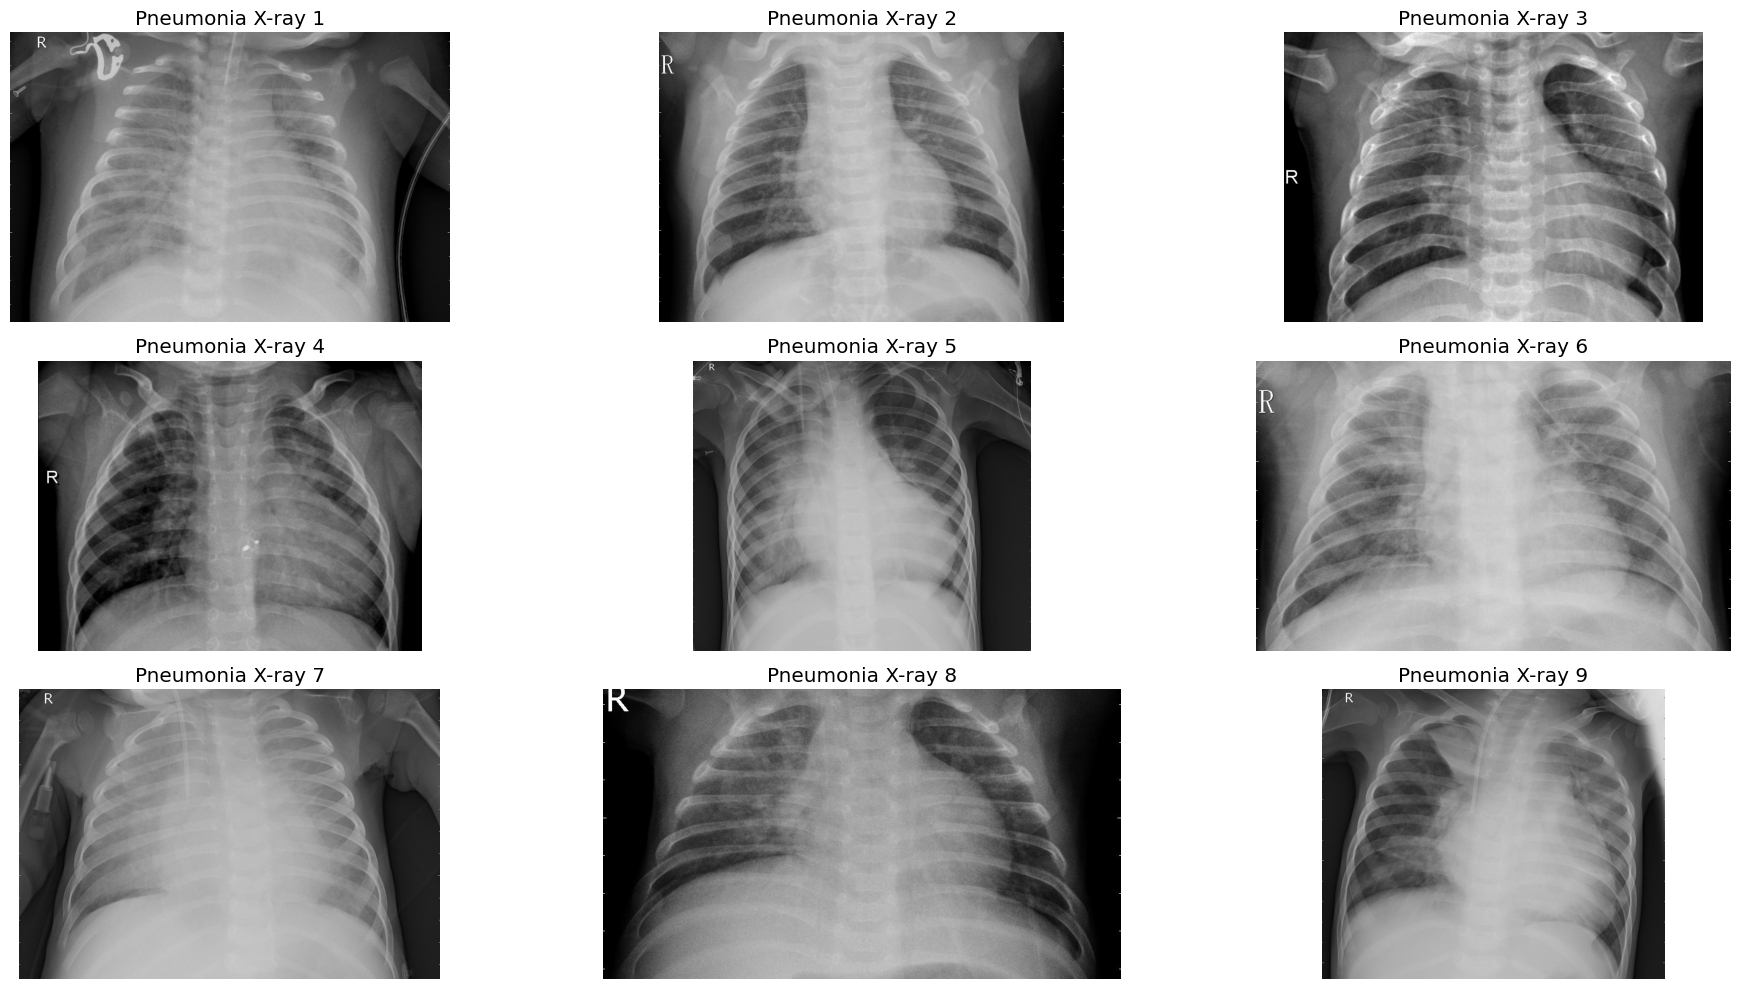

In [152]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np


plt.figure(figsize=(20,10))

for i in range(min(9, len(pneumonia))):  
    plt.subplot(3,3, i+1)
    img_path = os.path.join(pneumonia_dir, pneumonia[i])
    
    try:
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Pneumonia X-ray {i+1}")
        else:
            raise ValueError("Cannot read image")
            
    except Exception as e:
        plt.text(0.5, 0.5, f'Error\n{pneumonia[i]}', 
                 ha='center', va='center', fontsize=10, color='red',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        plt.title(f"Error - Image {i+1}")
    
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
normal_dir = os.path.join("archive", "chest_xray", "chest_xray", "train", "NORMAL")
normal = [f for f in os.listdir(normal_dir) if not f.startswith('.')]

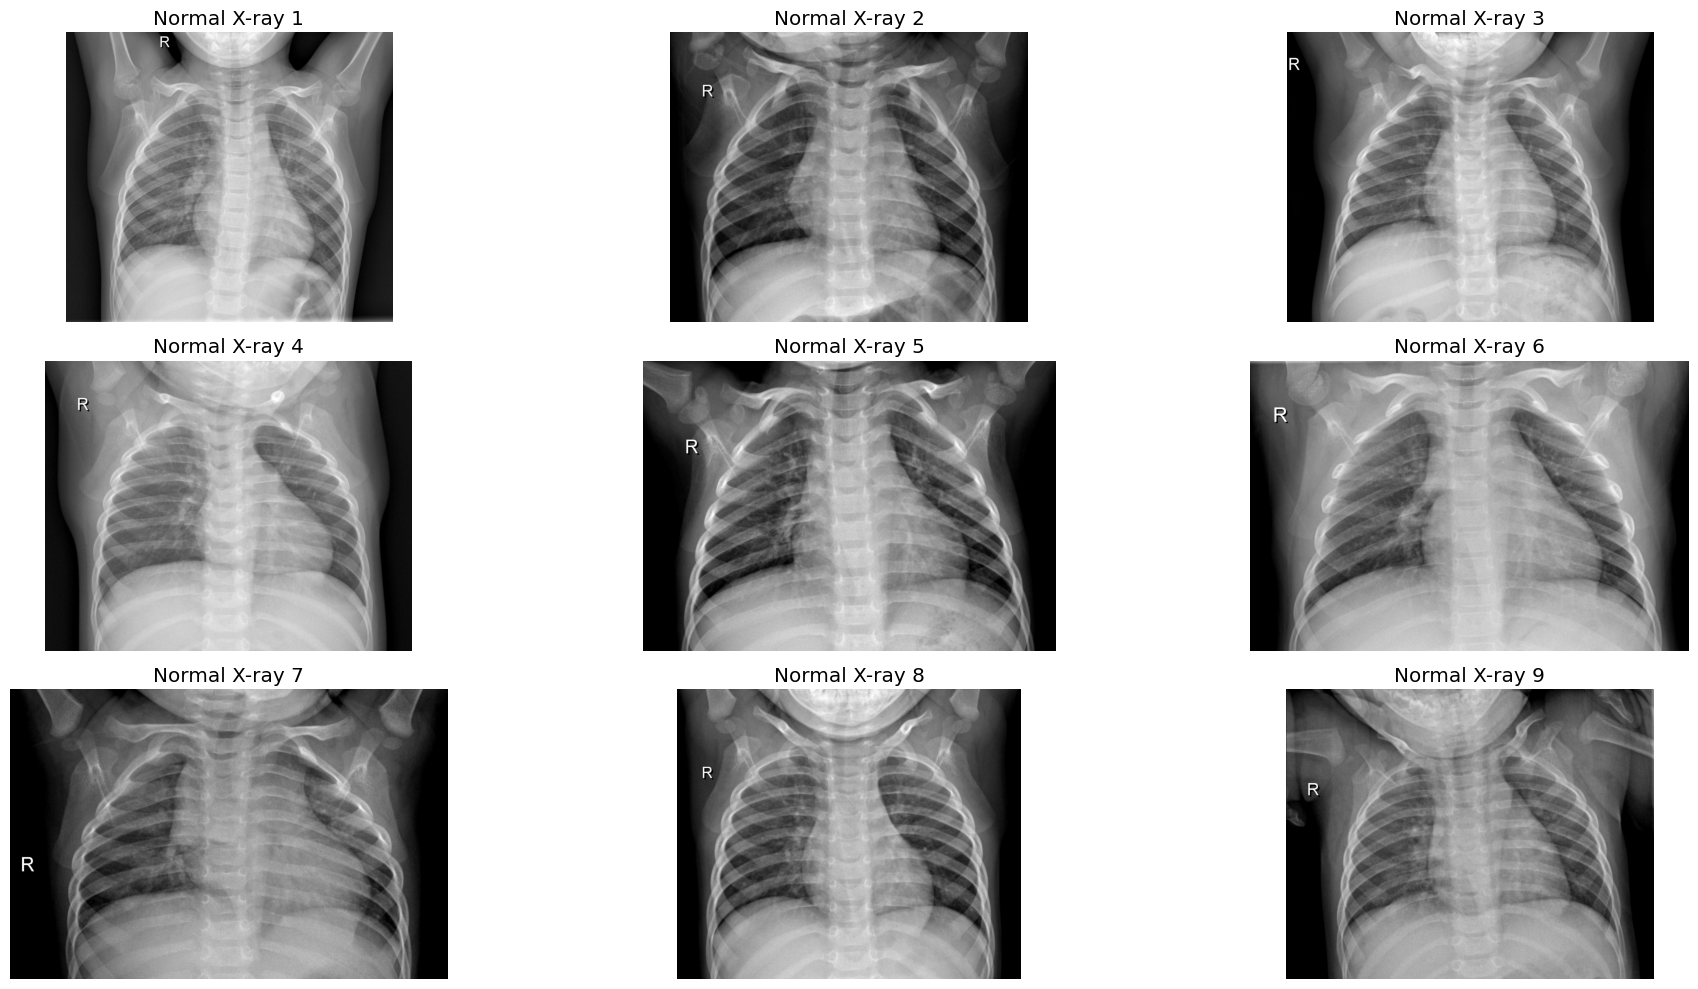

In [10]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np


plt.figure(figsize=(20,10))

for i in range(min(9, len(normal))):  
    plt.subplot(3,3, i+1)
    img_path = os.path.join(normal_dir, normal[i])
    
    try:
        img = cv2.imread(img_path)

        if img is not None:
         
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Normal X-ray {i+1}")
        else:
            raise ValueError("Cannot read image")
            
    except Exception as e:
        plt.text(0.5, 0.5, f'Error\n{normal[i]}', 
                 ha='center', va='center', fontsize=10, color='red',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        plt.title(f"Error - Image {i+1}")
    
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,         
    zoom_range=0.1,          
    horizontal_flip=True,    
    fill_mode='nearest'      
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    "archive/chest_xray/chest_xray/train",
    target_size=(128,128), 
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

valid_generator = valid_datagen.flow_from_directory(
    "archive/chest_xray/chest_xray/val",
    target_size=(128,128),  
    batch_size=32,
    class_mode='binary',
    shuffle=False, 
    seed=42,
    color_mode='rgb'
)

Found 5220 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


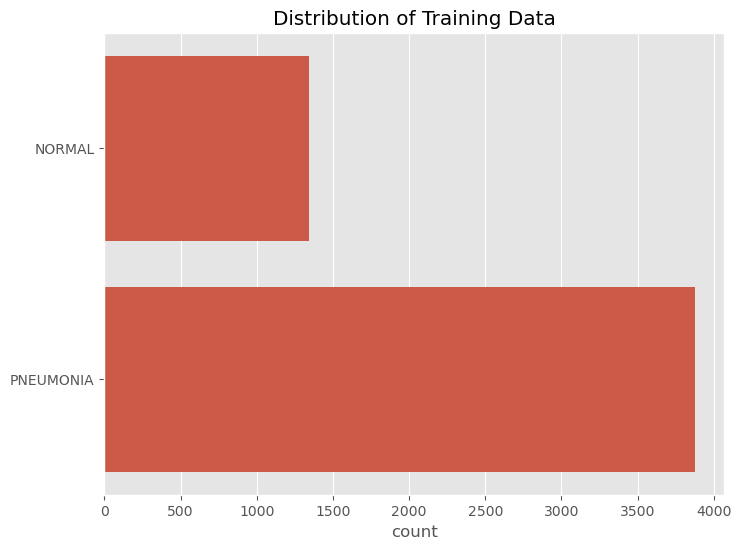

In [13]:
class_lables = train_generator.class_indices  # {'NORMAL': 0, 'PNEUMONIA': 1}

listx = []
for class_name, class_index in class_lables.items():
    path = os.path.join("archive", "chest_xray", "chest_xray", "train", class_name)
    n_files = len([f for f in os.listdir(path) if not f.startswith('.')])
    listx.extend([class_name] * n_files)

plt.figure(figsize=(8,6))
sns.countplot(listx)
plt.title("Distribution of Training Data")
plt.show()


In [14]:
class_lables = train_generator.class_indices
class_lables

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
class_name = {value:key for (value, key) in class_lables.items()}
class_name

{'NORMAL': 0, 'PNEUMONIA': 1}

In [78]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam


# VGG19 CNN Architecture
base_model = VGG19(input_shape=(128, 128, 3),
                   include_top=False,
                   weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)  
dropout = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)  
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_01 = Model(base_model.inputs, outputs=output)


# model_01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_01.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_01.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,189,761 (77.02 MB)

 Trainable params: 164,865 (644.00 KB)

 Non-trainable params: 20,024,896 (76.39 MB)

In [80]:
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
sp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [82]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 1.9448584202682564, 1: 0.6730273336771532}


In [84]:

# from tensorflow.keras.utils import image_dataset_from_directory
import os
test_datagen = ImageDataGenerator(rescale=1./255)

# Test generator
test_generator = test_datagen.flow_from_directory(
    "archive/chest_xray/chest_xray/test",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    shuffle=False, 
    color_mode='rgb'
)

# Training
history_01 = model_01.fit(
    train_generator,
    epochs=10,
    callbacks=[es, sp, lrr],
    validation_data=valid_generator,
    class_weight=class_weights_dict
)


vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_01[0]}, Accuracy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}, Accuracy: {vgg_test_eval_01[1]}")


Found 625 images belonging to 2 classes.
Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7383 - loss: 0.5040

164/164 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8006 - loss: 0.3926 - val_accuracy: 0.6875 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8730 - loss: 0.2773

164/164 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8835 - loss: 0.2652 - val_accuracy: 0.7500 - val_loss: 0.4610 - learning_rate: 1.0000e-04
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9021 - loss: 0.2237 - val_accuracy: 0.7500 - val_loss: 0.4948 - learning_rate: 1.0000e-04
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9145 - loss: 0.2127

164/164 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9163 - loss: 0.2105 - val_accuracy: 0.6875 - val_loss: 0.4499 - learning_rate: 1.0000e-04
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.9216 - loss: 0.1948 - val_accuracy: 0.7500 - val_loss: 0.4720 - learning_rate: 1.0000e-04
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9321 - loss: 0.1692

164/164 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9274 - loss: 0.1794 - val_accuracy: 0.7500 - val_loss: 0.3816 - learning_rate: 1.0000e-04
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9261 - loss: 0.1861

164/164 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9274 - loss: 0.1839 - val_accuracy: 0.7500 - val_loss: 0.3783 - learning_rate: 1.0000e-04
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.9257 - loss: 0.1780 - val_accuracy: 0.6875 - val_loss: 0.3903 - learning_rate: 1.0000e-04
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.9234 - loss: 0.1815 - val_accuracy: 0.6875 - val_loss: 0.4402 - learning_rate: 1.0000e-04
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.9257 - loss: 0.1702 - val_accuracy: 0.7500 - val_loss: 0.5320 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.5320
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8704 - loss: 0.3542
Validation Loss: 0.5319610834121704, Accuracy: 0.75
Test Loss: 0.35420164465904236, Accuracy: 0.8704000115394592


20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


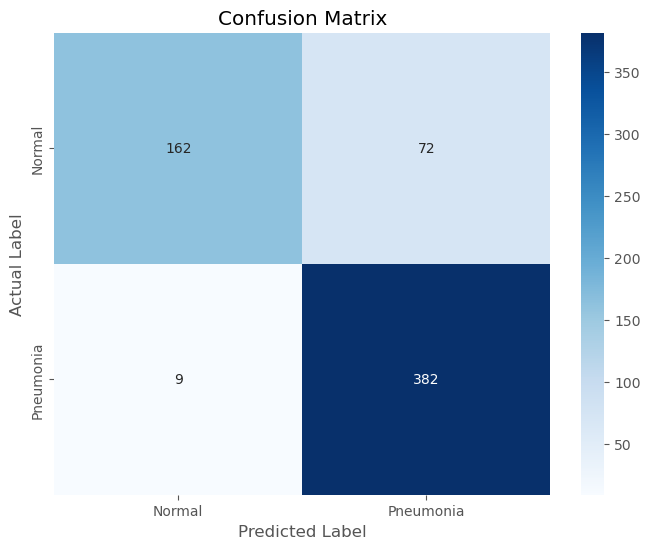

              precision    recall  f1-score   support

      Normal       0.95      0.69      0.80       234
   Pneumonia       0.84      0.98      0.90       391

    accuracy                           0.87       625
   macro avg       0.89      0.83      0.85       625
weighted avg       0.88      0.87      0.87       625



In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


Y_pred = model_01.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()


y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

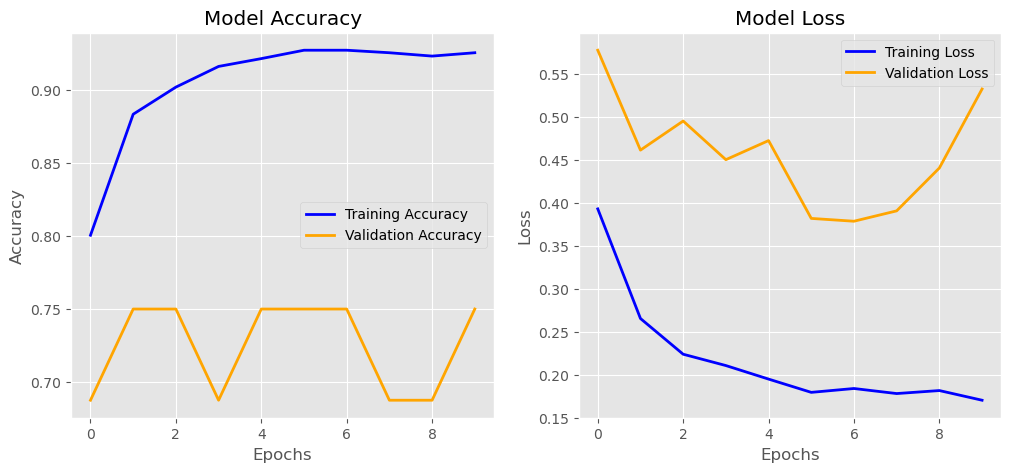

In [94]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_01.history['accuracy'], label='Training Accuracy', color='blue', lw=2)
plt.plot(history_01.history['val_accuracy'], label='Validation Accuracy', color='orange', lw=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_01.history['loss'], label='Training Loss', color='blue', lw=2)
plt.plot(history_01.history['val_loss'], label='Validation Loss', color='orange', lw=2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [96]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite = True)

In [98]:
test_generator = test_datagen.flow_from_directory(
    "archive/chest_xray/chest_xray/test",
    batch_size=32,
    target_size=(128,128),
    class_mode='binary', 
    shuffle=False,  
    seed=42,
    color_mode='rgb'
)

Found 625 images belonging to 2 classes.


In [100]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.5319610834121704
Validation Accuarcy: 0.75
Test Loss: 0.35420164465904236
Test Accuarcy: 0.8704000115394592


In [102]:
# model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.5320
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8704 - loss: 0.3542


In [56]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os


base_model = VGG19(include_top=False, input_shape=(128,128,3))


x = base_model.output
gap = GlobalAveragePooling2D()(x)
class_1 = Dense(256, activation='relu')(gap)  
dropout = Dropout(0.5)(class_1)
class_2 = Dense(64, activation='relu')(dropout) 
output = Dense(1, activation='sigmoid')(class_2)  # Binary Classification

model_02 = Model(base_model.inputs, output)


for layer in base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False


weights_path = "model_weights/vgg19_model_01.h5"
if os.path.exists(weights_path):
    try:
        model_02.load_weights(weights_path)
        print("Weights loaded successfully")
    except Exception as e:
        print(f"Cannot load weights: {e}\nProceeding without loading weights.")


print(model_02.summary())


Cannot load weights: Layer count mismatch when loading weights from file. Model expected 19 layers, found 20 saved layers.
Proceeding without loading weights.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,172,225 (76.95 MB)

 Trainable params: 4,867,457 (18.57 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [76]:
optimizer = Adam(learning_rate=1e-4)
model_02.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
sp = ModelCheckpoint("model_weights/vgg19_model_best.h5", save_best_only=True, monitor='val_loss', verbose=1)


history_02 = model_02.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    callbacks=[es, lrr, sp],
    validation_data=valid_generator
)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9619 - loss: 0.0987
Epoch 1: val_loss improved from None to 0.43385, saving model to model_weights/vgg19_model_best.h5



Epoch 1: finished saving model to model_weights/vgg19_model_best.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9626 - loss: 0.0968 - val_accuracy: 0.7500 - val_loss: 0.4338 - learning_rate: 1.0000e-04
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9694 - loss: 0.0980
Epoch 2: val_loss improved from 0.43385 to 0.30548, saving model to model_weights/vgg19_model_best.h5



Epoch 2: finished saving model to model_weights/vgg19_model_best.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.9684 - loss: 0.0940 - val_accuracy: 0.8125 - val_loss: 0.3055 - learning_rate: 1.0000e-04
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9713 - loss: 0.0815
Epoch 3: val_loss did not improve from 0.30548
164/164 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9709 - loss: 0.0847 - val_accuracy: 0.7500 - val_loss: 0.3138 - learning_rate: 1.0000e-04
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9720 - loss: 0.0797
Epoch 4: val_loss improved from 0.30548 to 0.20907, saving model to model_weights/vgg19_model_best.h5



Epoch 4: finished saving model to model_weights/vgg19_model_best.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9720 - loss: 0.0775 - val_accuracy: 0.8750 - val_loss: 0.2091 - learning_rate: 1.0000e-04
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - loss: 0.0920
Epoch 5: val_loss did not improve from 0.20907
164/164 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9688 - loss: 0.0880 - val_accuracy: 0.7500 - val_loss: 0.3143 - learning_rate: 1.0000e-04
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9699 - loss: 0.0808
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 6: val_loss did not improve from 0.20907
164/164 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9726 - loss: 0.0788 - val_accuracy: 0.8750 - val_loss: 0.2135 - learning_rate: 1.0000e-04
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9770 - loss: 0.0681
Epoch 7: val_loss improved from 0.20907 to 0.15045, saving model to


Epoch 7: finished saving model to model_weights/vgg19_model_best.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9745 - loss: 0.0721 - val_accuracy: 0.9375 - val_loss: 0.1505 - learning_rate: 5.0000e-05
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9756 - loss: 0.0594
Epoch 8: val_loss did not improve from 0.15045
164/164 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.9743 - loss: 0.0644 - val_accuracy: 0.8750 - val_loss: 0.1651 - learning_rate: 5.0000e-05
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9737 - loss: 0.0724
Epoch 9: val_loss improved from 0.15045 to 0.08978, saving model to model_weights/vgg19_model_best.h5



Epoch 9: finished saving model to model_weights/vgg19_model_best.h5
164/164 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9734 - loss: 0.0711 - val_accuracy: 1.0000 - val_loss: 0.0898 - learning_rate: 5.0000e-05
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9735 - loss: 0.0632
Epoch 10: val_loss did not improve from 0.08978
164/164 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9745 - loss: 0.0648 - val_accuracy: 0.9375 - val_loss: 0.1629 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.


20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


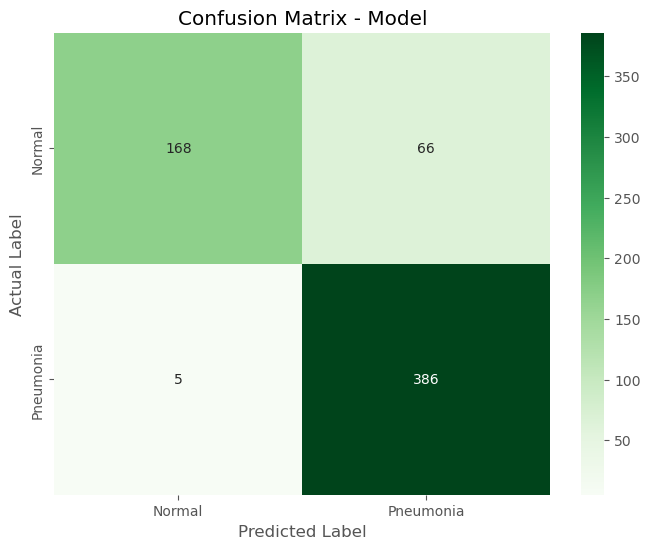

              precision    recall  f1-score   support

      Normal       0.97      0.72      0.83       234
   Pneumonia       0.85      0.99      0.92       391

    accuracy                           0.89       625
   macro avg       0.91      0.85      0.87       625
weighted avg       0.90      0.89      0.88       625



In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Y_pred_02 = model_02.predict(test_generator)
y_pred_02 = (Y_pred_02 > 0.5).astype(int).flatten() 

y_true = test_generator.classes

cm_02 = confusion_matrix(y_true, y_pred_02)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_02, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_true, y_pred_02, target_names=['Normal', 'Pneumonia']))


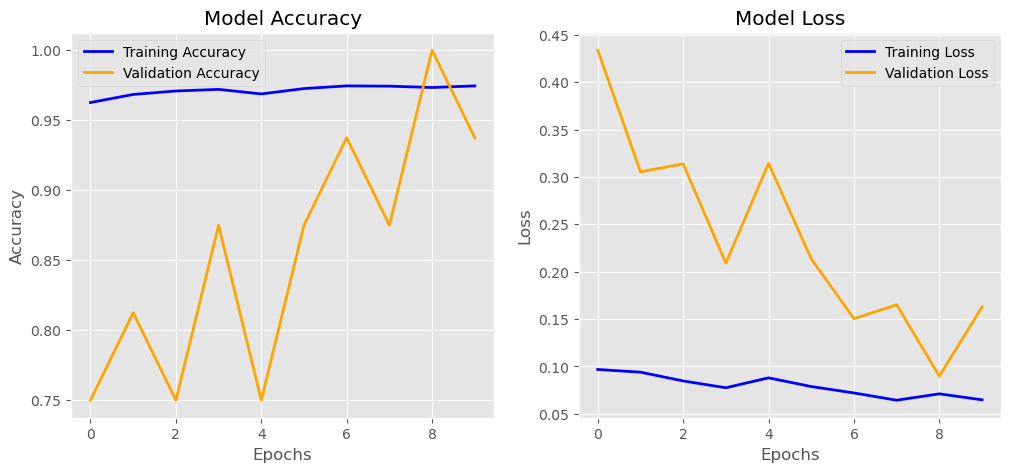

In [116]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_02.history['accuracy'], label='Training Accuracy', color='blue', lw=2)
plt.plot(history_02.history['val_accuracy'], label='Validation Accuracy', color='orange', lw=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history_02.history['loss'], label='Training Loss', color='blue', lw=2)
plt.plot(history_02.history['val_loss'], label='Validation Loss', color='orange', lw=2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

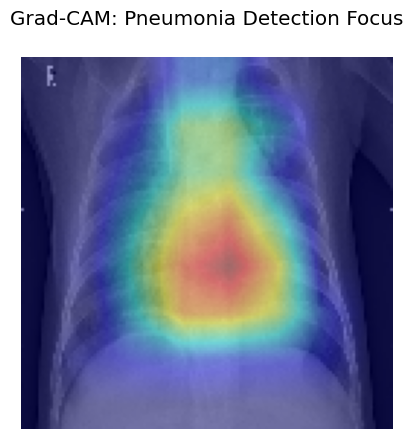

In [148]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

 
    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


last_conv_layer_name = "block5_conv3"


img_path = 'archive/chest_xray/test/PNEUMONIA/person121_bacteria_578.jpeg'
img = keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


heatmap = make_gradcam_heatmap(img_array, model_02, last_conv_layer_name)


plt.matshow(heatmap)



import cv2

# تحميل الصورة الأصلية
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))


heatmap_resized = cv2.resize(heatmap, (128, 128))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)


superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)


plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM: Pneumonia Detection Focus")
plt.axis('off')
plt.show()

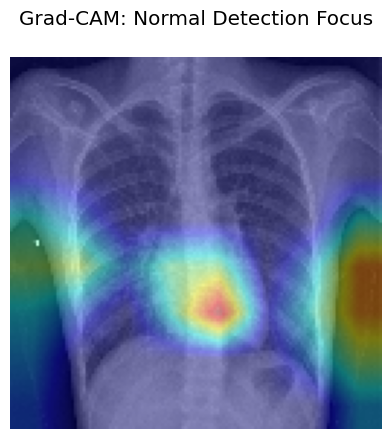

In [138]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


last_conv_layer_name = "block5_conv3"


img_path = 'archive/chest_xray/chest_xray/test/NORMAL/IM-0028-0001.jpeg'
img = keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


heatmap = make_gradcam_heatmap(img_array, model_02, last_conv_layer_name)


plt.matshow(heatmap)



import cv2


img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))

heatmap_resized = cv2.resize(heatmap, (128, 128))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)


superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)


plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM: Normal Detection Focus")
plt.axis('off')
plt.show()

In [60]:
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
 
model_02.compile(loss="binary_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [70]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite = True)

In [72]:
from tensorflow.keras.utils import image_dataset_from_directory

test_dir = 'C:\\Users\\enasr\\pneumonia detection\\archive\\chest_xray\\chest_xray\\test'

test_gen = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128), 
    batch_size=32,
    label_mode='binary',
    shuffle=False
)


Found 625 files belonging to 2 classes.


In [74]:

weights_path = "model_weights/vgg19_model_02.h5"
if os.path.exists(weights_path):
    try:
        model_02.load_weights(weights_path)
        print("Weights loaded successfully")
    except Exception as e:
        print(f"Cannot load weights: {e}\nProceeding without loading weights.")

vgg_val_eval_02 = model_02.evaluate(valid_generator)

vgg_test_eval_02 = model_02.evaluate(test_generator)


Weights loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - accuracy: 0.8750 - loss: 0.2446
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8928 - loss: 0.3654


In [68]:
print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

Validation Loss: 0.24457907676696777
Validation Accuarcy: 0.875
Test Loss: 0.36538252234458923
Test Accuarcy: 0.892799973487854


In [31]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
gap = GlobalAveragePooling2D()(x)


class_1 = Dense(256, activation='relu')(gap)  
dropout = Dropout(0.5)(class_1)
class_2 = Dense(128, activation='relu')(dropout)  
output = Dense(1, activation='sigmoid')(class_2)

model_03 = Model(base_model.inputs, output)
weights_path = "model_weights/vgg19_model_01.h5"
if os.path.exists(weights_path):
    try:
        model_03.load_weights(weights_path)
        print("Weights loaded successfully")
    except Exception as e:
        print(f"Cannot load weights: {e}\nProceeding without loading weights.")

print(model_03.summary())

Cannot load weights: Shape mismatch in layer #16 (named dense_6)for weight dense_6/kernel. Weight expects shape (8192, 512). Received saved weight with shape (512, 256)
Proceeding without loading weights.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,284,993 (92.64 MB)

 Trainable params: 24,284,993 (92.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
 
model_03.compile(loss="binary_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [34]:
history_03 = model_03.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs=1,
    callbacks=[es, sp, lrr],
    validation_data=valid_generator
)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6894 - loss: 0.5709
Epoch 1: val_loss did not improve from 0.26939
100/100 ━━━━━━━━━━━━━━━━━━━━ 648s 6s/step - accuracy: 0.7721 - loss: 0.4623 - val_accuracy: 0.7500 - val_loss: 0.7359 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 962ms/step


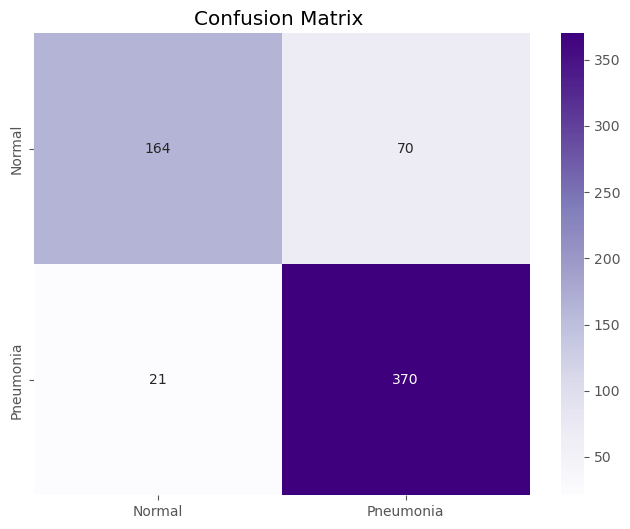

Classification Report for Model:
              precision    recall  f1-score   support

      Normal       0.89      0.70      0.78       234
   Pneumonia       0.84      0.95      0.89       391

    accuracy                           0.85       625
   macro avg       0.86      0.82      0.84       625
weighted avg       0.86      0.85      0.85       625



In [122]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_pred_03 = model_03.predict(test_generator)
y_pred_03 = (Y_pred_03 > 0.5).astype(int).flatten()


cm_03 = confusion_matrix(test_generator.classes, y_pred_03)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_03, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix ')
plt.show()


print("Classification Report for Model:")
print(classification_report(test_generator.classes, y_pred_03, target_names=['Normal', 'Pneumonia']))

In [35]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite = True)

In [38]:
model_03.save('pneumonia_model_final.keras')

from tensorflow.keras.models import load_model
model_test = load_model('pneumonia_model_final.keras')
print("Model is ready for Flask deployment!")

Model is ready for Flask deployment!
